# HL-LHC simple roration (α,β,γ included)
- You create a particles' distribution in x and y and create the footprint. 
- The values of k3L, xmax and ymax were choosen randomly so they are handy for the observations. They do not correspond to real values.
- Tune is calculated by PyNAFF.
- In the last cells the footprint is compared to the one obtained from SixTrack

In [1]:
import os
import sys
import random
import numpy as np
from math import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import PyNAFF as pnf
from dotted_dict import DottedDict
sys.path.append('./utils')
from my_elements import *
from my_machines import *
#from cl2pd import importData

# Plotting parameters

In [2]:
params = {'legend.fontsize': 12,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 18,
          'axes.titlesize': 18,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

# Rotation map

\begin{equation}
  M_{rotation}=
  \left[ {\begin{array}{cc}
   \cos 2 \pi Q_x + \alpha _x \sin 2 \pi Q_x & \beta _ x\sin 2 \pi Q_x\\
   -\gamma _ x \sin 2 \pi Q_x & \cos 2 \pi Q_x -\alpha_x \sin 2 \pi Q_x \\
  \end{array} } \right]
\end{equation}

# Octupole map

\begin{equation}
p_x = p_x - \frac{k_3}{6}(x^3-3xy^2) \\ 
p_y = p_y - \frac{k_3}{6}(y^3-3yx^2)
\end{equation}

# Choose the elements that you add in the machine

In [3]:
n_segments = 8 # NUmber of segmetns/arcs
flag_oct = True
k3_int = 10000. # octupole integrated strength
flag_noise = False
Delta = 0.05 # amplitude of the noise

# Define study parameters

In [4]:
n_turns = 2000  # Number of turns
step = 20 # Number of  particles
n_particles = step**2
Qx_init = 2*pi*62.24#31  # Horizontal tune, "init" cause it changes during the tracking due to detuning with amplitude
Qy_init = 2*pi*62.32  # Vertical tune

gamma_rel = 7460.52252807237 #relativistic gamma from madx (twiss)
beta_rel = sqrt(1-(1/gamma_rel)**2)
ex_norm = 2.5e-6 #[μm] normalised emittance 
ey_norm = ex_norm

twiss = DottedDict()
twiss.beta_x = 115.75 # for IP3, obtained from madx-twiss
twiss.beta_y = 213.65 # for IP3
twiss.alpha_x = twiss.alpha_y = 0. # even though they are not actually 0

f_rev = 11.2455e3 #[Hz] revolution frequency 

# Calculate beam sigma

\begin{equation}
\sigma = \sqrt{e_{geom}\beta(s)} \\
e_{geom}  = \frac{e_{norm}}{\beta_{rel}\gamma_{rel}}
\end{equation}

In [5]:
ex_geom = ex_norm/(beta_rel*gamma_rel)
ey_geom = ey_norm/(beta_rel*gamma_rel)

sigma_x = sqrt(twiss.beta_x*ex_geom)
sigma_y = sqrt(twiss.beta_y*ey_geom)
sigma_px = sqrt(ex_geom/twiss.beta_x)
sigma_py = sqrt(ey_geom/twiss.beta_y)

In [6]:
print('6sigma_x', 6*sigma_x)
print('6sigma_y', 6*sigma_y)

6sigma_x 0.0011816725129329356
6sigma_y 0.001605417830675162


### Create initial distribution

In [7]:
# 2D Grid up to 6 sigma
grid = True
gaussian = False
uniform = False
if grid:
    x_max = 6*sigma_x # usually up to 6 sigma you have vrey few particles
    y_max = 6*sigma_y 
    x_array = np.linspace(1e-12,x_max,step) #1D arrays to create the grid
    y_array = np.linspace(1e-12,y_max,step)
    xx, yy = np.meshgrid(x_array,y_array)
    x_initial = xx.flatten() #collpase the coordinates in one direction
    y_initial = yy.flatten()
    px_initial = np.zeros(n_particles)
    py_initial = np.zeros(n_particles)
if gaussian:
    x_array= np.random.normal(0,1, n_particles)*2*sigma_x 
    y_array= np.random.normal(0,1, n_particles)*2*sigma_y 
    x_initial = x_array
    y_initial = y_array
    px_initial = np.zeros(n_particles)
    py_initial = np.zeros(n_particles)

### Create bunch

In [8]:
bunch = DottedDict()

bunch.x = x_initial
bunch.px = px_initial
bunch.y = y_initial
bunch.py = py_initial

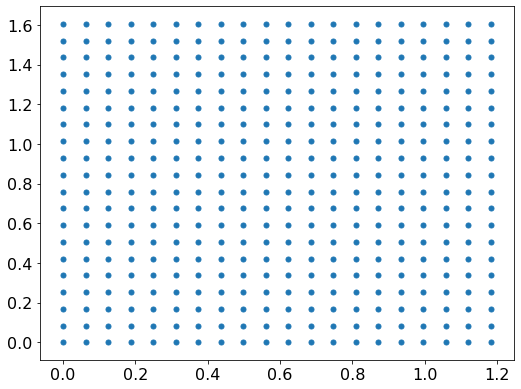

In [9]:
plt.scatter(bunch.x*1e3, bunch.y*1e3)

### Create list for turn by turn data

In [10]:
x_list = np.empty([n_particles,n_turns])
px_list = np.empty([n_particles,n_turns])
y_list = np.empty([n_particles,n_turns])
py_list = np.empty([n_particles,n_turns])

### Tracking

In [11]:
for turn in range(n_turns-1):
    my_machine(Qx_init, Qy_init, n_segments, turn, bunch, twiss, flag_oct, k3_int)
    x_list[:,turn]  = bunch.x
    px_list[:,turn]  = bunch.px
    y_list[:,turn]  = bunch.y
    py_list[:,turn]  = bunch.py



flag oct True


### Phase space 

Text(0.5, 0, '$px_{norm}  \\cdot 10^3 $')

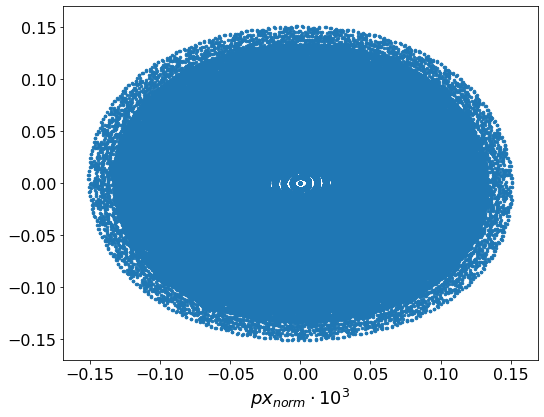

In [12]:
plt.scatter(x_list*1e3/sqrt(twiss.beta_x), px_list*1e3*sqrt(twiss.beta_x), marker='.')
plt.xlabel(r'$x_{norm} \cdot 10^3$')
plt.xlabel(r'$px_{norm}  \cdot 10^3 $')
#plt.scatter(y_list[40:70]*1e3/sqrt(twiss.beta_y), py_list[40:70]*1e3*sqrt(twiss.beta_y), marker='.')

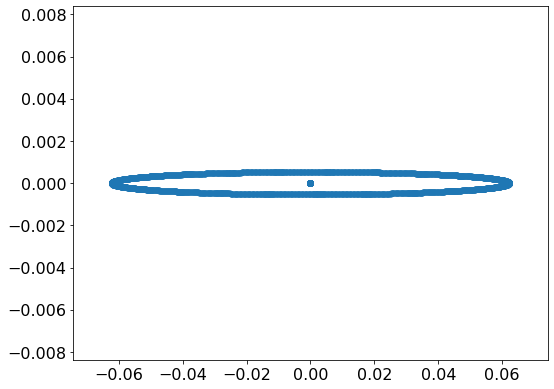

In [26]:
plt.scatter(x_list[:2][:2]*1e3,px_list[:2][:2]*1e3)

In [29]:
x_list[0].shape

(2000,)

# Normalise the turn by turn data
For alpha =0

\begin{equation}
x_{norm} = \frac{x}{\sqrt{\beta}} \\
p_{x_{norm} = p_{x} \sqrt{\beta}}
\end{equation}

In [13]:
#A. Calculate the tune of each particle with NAFF. We must exclude the particles that are lost during the tracking as NAFF can't process them.
bad_particles = []
Qx_list = []
Qy_list = []
for particle in range(n_particles):
    if np.isnan(x_list[particle,:]).any() or np.isnan(px_list[particle,:]).any():
        bad_particles.append(particle)
    else:
        signal_x = x_list[particle]/sqrt(twiss.beta_x)
        signal_y = y_list[particle]/sqrt(twiss.beta_y)
    
        Qx_list.append(pnf.naff(signal_x,n_turns,1,0,False)[0][1])
        Qy_list.append(pnf.naff(signal_y,n_turns,1,0,False)[0][1])
   

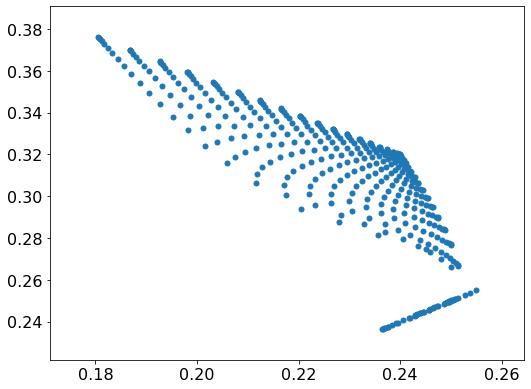

In [14]:
plt.scatter(Qx_list, Qy_list)
#plt.savefig('./hahah.png')